# Beta Lactamase Bioactive molecule prediction

## Introduction

* https://github.com/dataprofessor/beta-lactamase
* https://github.com/sayalaruano/MidtermProject-MLZoomCamp
* https://github.com/wguesdon/beta-lactamase
* https://www.youtube.com/watch?v=_GtEgiWWyK4 
* https://youtu.be/rEmDyZHz5U8

This project aims to build models predicting molecules binding to the Beta-Lactamase protein. The project will be our first open bioinformatics research paper. For the complete project description, see this [video](https://www.youtube.com/watch?v=_GtEgiWWyK4) on the [Data Professor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) channel.

## 1 Initialization

In [ ]:
###################
# 1 Initialization
###################

# 1.1 Clean up Data folder after previous iteration of the script
!rm /content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/*.csv > NULL
!rm /content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/Raw_files/* > NULL
!rm /content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/Fingerprints/* > NULL

# 1.2 Install required libraries
!pip install wget > NULL
! pip install padelpy > NULL

# 1.3 Load libraries
import os
from pathlib import Path # for path in Windows and Unix
import wget
import zipfile
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

# 1.4 Define the working folders
# see https://careerkarma.com/blog/python-list-files-in-directory/
# See https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f
project_folder = Path('/content/drive/MyDrive/Bioinformatics/Beta-lactamase/')
project_data_folder = Path('/content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/')
project_result_folder = Path('/content/drive/MyDrive/Bioinformatics/Beta-lactamase/Output/')
#os.listdir(project_data_folder)

# 1.5 Donwload the dataset
# see https://likegeeks.com/downloading-files-using-python/
url = 'https://github.com/dataprofessor/beta-lactamase/raw/main/beta_lactamase_CHEMBL29.zip'
file_path = project_data_folder / 'Raw_files' / 'beta_lactamase_CHEMBL29.zip'
file_path = str(file_path)
wget.download(url, file_path)
#os.listdir(project_data_folder)

# 1.6 unzip file
# see https://stackoverflow.com/questions/3451111/unzipping-files-in-python
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(project_data_folder)

#os.listdir(project_data_folder)

# 1.7 concatenate all csv file in one Data Frame
# see https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
zf = zipfile.ZipFile(file_path, "r")
df = pd.concat( (pd.read_csv( zf.open(f) ) for f in zf.namelist() ) )
df

rm: cannot remove '/content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/*.csv': No such file or directory


,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
0,CHEMBL1730,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(C)...,=,10.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
1,CHEMBL996,CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...,NaN,NaN,NaN,Kcat/Km,NaN,Gil1,assay format
2,CHEMBL617,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)Cc3ccc...,=,598.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
3,CHEMBL702,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3[C@@H...,=,3400.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
4,CHEMBL1449,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](C(=O)O)c3ccsc3...,=,10000.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
...,...,...,...,...,...,...,...,...,...
13,CHEMBL561555,COC(=O)CC(N)(CC(=O)OC)C(=O)OCc1ccccc1,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
14,CHEMBL561821,NC(CC(=O)OCc1ccccc1)(CC(=O)OCc1ccccc1)C(=O)OCc...,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
15,CHEMBL561896,COC(=O)CC(CC(=O)OC)(NC(=O)Cc1ccccc1)C(=O)OC,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
16,CHEMBL563044,COC(=O)C(CC(=O)OCc1ccccc1)(CC(=O)OCc1ccccc1)NC...,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format


In [ ]:
# 1.8 Remove row with missing canonical_smiles and missing pchembl_value
df = df[df['canonical_smiles'].notna()]
df = df[df['pchembl_value'].notna()]

#1.9 Extract from the dataset the majority molecule: molecule_chembl_id
# see https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
df = df[df['target_pref_name'] == 'Beta-lactamase AmpC']
df = df[df['standard_type'] == 'Potency']
df == df[df['bao_label'] == 'assay format']
df

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
625,CHEMBL260148,CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...,=,1800.0,nM,Potency,5.75,Beta-lactamase AmpC,assay format
626,CHEMBL1341981,Cc1ccccc1CS(=O)(=O)c1nnc([C@H](CC(C)C)NC(=O)OC...,=,11000.0,nM,Potency,4.96,Beta-lactamase AmpC,assay format
627,CHEMBL1401211,CC(C)C[C@H](N)c1nnc(S(=O)(=O)Cc2cccc(F)c2)o1.Cl,=,8600.0,nM,Potency,5.07,Beta-lactamase AmpC,assay format
628,CHEMBL259018,CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...,=,66.0,nM,Potency,7.18,Beta-lactamase AmpC,assay format
629,CHEMBL1365696,CCC(C)[C@@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc...,=,10000.0,nM,Potency,5.00,Beta-lactamase AmpC,assay format
...,...,...,...,...,...,...,...,...,...
62340,CHEMBL1448055,COc1ccc(NC(=O)CN2CCN(c3ccc(C)cc3C)CC2)cc1,=,5623.4,nM,Potency,5.25,Beta-lactamase AmpC,assay format
62341,CHEMBL1439828,O=C(COc1ccccc1[N+](=O)[O-])N1CCN(c2ccccn2)CC1,=,1778.3,nM,Potency,5.75,Beta-lactamase AmpC,assay format
62342,CHEMBL1450737,O=C(O)c1ccc2c(c1)N(Cc1ccccc1)C(=O)c1ccccc1[S+]...,=,7943.3,nM,Potency,5.10,Beta-lactamase AmpC,assay format
62343,CHEMBL1450738,CCOC(=O)CSc1nnc(-c2ccoc2C)n1-c1ccc(C)cc1,=,3981.1,nM,Potency,5.40,Beta-lactamase AmpC,assay format


In [ ]:
# 1.10 Removes duplicated noleculres
# From https://github.com/sayalaruano/MidtermProject-MLZoomCamp/blob/main/EDA_beta_lactamase_drug_discovery_project.ipynb

def combine_molecule_duplicates(dataset):
    '''
    Function to replace duplicated molecules by one single row with mean of standard_value and 
    pchembl_value of duplicated rows. The replacement is applied only if standard deviation of 
    pchembl_value is lower than 2.

        Parameters:
            dataset (DataFrame): A pandas DataFrame with duplicated molecules
        
        Returns: 
            dataset (DataFrame): A pandas DataFrame without duplicated molecules
    '''
    # Calculate standard deviation of all molecules
    std_by_uniqueID = dataset.groupby("molecule_chembl_id").std()

    # Filter standard deviation of duplicated molecules lower than 2
    std_by_uniqueID = std_by_uniqueID[std_by_uniqueID.pchembl_value < 2]

    # Calculate mean of all molecules
    mean_by_uniqueID = dataset.groupby("molecule_chembl_id").mean()
    
    # Filter mean of duplicated molecules that have standard deviation lower than 2
    mean_by_uniqueID = mean_by_uniqueID.filter(items = std_by_uniqueID.index, axis=0)

    # Create a dictionary of rows with mean values of standard_value and pchembl_value
    new_rows = {}

    for i in mean_by_uniqueID.index:
        rows = dataset.loc[dataset.molecule_chembl_id == i].copy()
        row = rows.iloc[0].copy()
        row.standard_value = mean_by_uniqueID.loc[i].standard_value
        row.pchembl_value = mean_by_uniqueID.loc[i].pchembl_value
        new_rows[i] = row
    
    # Convert dictionary to dataframa
    df_new_rows = pd.DataFrame(new_rows).T
    
    # Delete duplicated molecules from the original dataset
    dataset = dataset.drop_duplicates(subset=["molecule_chembl_id"], keep=False)

    # Add new rows to the original dataset
    dataset = pd.concat([dataset, df_new_rows], axis=0).reset_index(drop=True)

    return dataset

# Replace duplicated molecules by mean of their standard_value and pchembl_value
df = combine_molecule_duplicates(df)
df

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
0,CHEMBL1401836,COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC,=,79432.8,nM,Potency,4.1,Beta-lactamase AmpC,assay format
1,CHEMBL554891,Cl.c1ccc(C2CN3CCSC3=N2)cc1,=,631,nM,Potency,6.2,Beta-lactamase AmpC,assay format
2,CHEMBL1519543,CCOc1ccc(CCNC(=O)Cn2ncn3c(cc4ccccc43)c2=O)cc1OCC,=,631,nM,Potency,6.2,Beta-lactamase AmpC,assay format
3,CHEMBL1401837,O=C(Nc1ccc2c(c1)OCO2)c1cc(C2CC2)on1,=,5623.4,nM,Potency,5.25,Beta-lactamase AmpC,assay format
4,CHEMBL2369239,CCCCCCOc1ccc(N2C(=O)CC(SC(=N)N/N=C(\C)c3cccs3)...,=,63095.7,nM,Potency,4.2,Beta-lactamase AmpC,assay format
...,...,...,...,...,...,...,...,...,...
61586,CHEMBL259018,CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...,=,191.1,nM,Potency,6.84,Beta-lactamase AmpC,assay format
61587,CHEMBL260148,CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...,=,1897.65,nM,Potency,5.725,Beta-lactamase AmpC,assay format
61588,CHEMBL268869,COc1ccc(NS(=O)(=O)c2ccc(N)cc2)nn1,=,94562.6,nM,Potency,4.025,Beta-lactamase AmpC,assay format
61589,CHEMBL411070,C[C@H](CCC(=O)NCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@...,=,2115.45,nM,Potency,5.7,Beta-lactamase AmpC,assay format


## 2 Data Wrangling

In [ ]:
df2 = df[['canonical_smiles', 'molecule_chembl_id']]
file_path = project_data_folder / 'molecule.smi'
df2.to_csv(file_path, sep='\t', index=False, header=False)
df2

,canonical_smiles,molecule_chembl_id
0,COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC,CHEMBL1401836
1,Cl.c1ccc(C2CN3CCSC3=N2)cc1,CHEMBL554891
2,CCOc1ccc(CCNC(=O)Cn2ncn3c(cc4ccccc43)c2=O)cc1OCC,CHEMBL1519543
3,O=C(Nc1ccc2c(c1)OCO2)c1cc(C2CC2)on1,CHEMBL1401837
4,CCCCCCOc1ccc(N2C(=O)CC(SC(=N)N/N=C(\C)c3cccs3)...,CHEMBL2369239
...,...,...
61586,CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...,CHEMBL259018
61587,CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...,CHEMBL260148
61588,COc1ccc(NS(=O)(=O)c2ccc(N)cc2)nn1,CHEMBL268869
61589,C[C@H](CCC(=O)NCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@...,CHEMBL411070


In [6]:
# 2.1 Use PaDelPy to convert smiles annotation to chemical structures infomrmations
# https://opensourcelibs.com/lib/padelpy
# https://youtu.be/rEmDyZHz5U8
# https://github.com/dataprofessor/padel

url = 'https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip'
file_path = project_data_folder / 'Fingerprints' / 'fingerprints_xml.zip'
file_path = str(file_path)
wget.download(url, file_path)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(str(project_data_folder / 'Fingerprints'))

xml_files = glob.glob(str(project_data_folder / 'Fingerprints/*.xml'))
xml_files.sort()
#xml_files

FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

fp = dict(zip(FP_list, xml_files))
#fp

from padelpy import padeldescriptor

fingerprint = 'Substructure'

fingerprint_output_file = str(project_data_folder / 'Substructure.csv')
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(#mol_dir='molecule.smi', 
                mol_dir = str(project_data_folder / 'molecule.smi'),
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

descriptors = pd.read_csv(fingerprint_output_file)
descriptors

,Name,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,SubFP11,SubFP12,SubFP13,SubFP14,SubFP15,SubFP16,SubFP17,SubFP18,SubFP19,SubFP20,SubFP21,SubFP22,SubFP23,SubFP24,SubFP25,SubFP26,SubFP27,SubFP28,SubFP29,SubFP30,SubFP31,SubFP32,SubFP33,SubFP34,SubFP35,SubFP36,SubFP37,SubFP38,SubFP39,...,SubFP268,SubFP269,SubFP270,SubFP271,SubFP272,SubFP273,SubFP274,SubFP275,SubFP276,SubFP277,SubFP278,SubFP279,SubFP280,SubFP281,SubFP282,SubFP283,SubFP284,SubFP285,SubFP286,SubFP287,SubFP288,SubFP289,SubFP290,SubFP291,SubFP292,SubFP293,SubFP294,SubFP295,SubFP296,SubFP297,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL554891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
1,CHEMBL1401836,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
2,CHEMBL1401837,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
3,CHEMBL1519543,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
4,CHEMBL1410086,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61586,CHEMBL1599088,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1
61587,CHEMBL268869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
61588,CHEMBL260148,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
61589,CHEMBL85799,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1


In [11]:
file_path = project_result_folder / 'beta-lactamase_descriptors.csv'
descriptors.to_csv(file_path, index=False)

In [8]:
# combine descriptor and filtered dataset
df3 = pd.merge(df, descriptors, how ="inner", left_on=['molecule_chembl_id'], right_on=['Name'])

file_path = project_result_folder / 'beta-lactamase_filtered_dataset.csv'
df3.to_csv(file_path, index=False)

In [9]:
df3

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label,Name,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,SubFP11,SubFP12,SubFP13,SubFP14,SubFP15,SubFP16,SubFP17,SubFP18,SubFP19,SubFP20,SubFP21,SubFP22,SubFP23,SubFP24,SubFP25,SubFP26,SubFP27,SubFP28,SubFP29,SubFP30,...,SubFP268,SubFP269,SubFP270,SubFP271,SubFP272,SubFP273,SubFP274,SubFP275,SubFP276,SubFP277,SubFP278,SubFP279,SubFP280,SubFP281,SubFP282,SubFP283,SubFP284,SubFP285,SubFP286,SubFP287,SubFP288,SubFP289,SubFP290,SubFP291,SubFP292,SubFP293,SubFP294,SubFP295,SubFP296,SubFP297,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL1401836,COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC,=,79432.8,nM,Potency,4.1,Beta-lactamase AmpC,assay format,CHEMBL1401836,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
1,CHEMBL554891,Cl.c1ccc(C2CN3CCSC3=N2)cc1,=,631,nM,Potency,6.2,Beta-lactamase AmpC,assay format,CHEMBL554891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
2,CHEMBL1519543,CCOc1ccc(CCNC(=O)Cn2ncn3c(cc4ccccc43)c2=O)cc1OCC,=,631,nM,Potency,6.2,Beta-lactamase AmpC,assay format,CHEMBL1519543,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
3,CHEMBL1401837,O=C(Nc1ccc2c(c1)OCO2)c1cc(C2CC2)on1,=,5623.4,nM,Potency,5.25,Beta-lactamase AmpC,assay format,CHEMBL1401837,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
4,CHEMBL2369239,CCCCCCOc1ccc(N2C(=O)CC(SC(=N)N/N=C(\C)c3cccs3)...,=,63095.7,nM,Potency,4.2,Beta-lactamase AmpC,assay format,CHEMBL2369239,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61586,CHEMBL259018,CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...,=,191.1,nM,Potency,6.84,Beta-lactamase AmpC,assay format,CHEMBL259018,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
61587,CHEMBL260148,CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...,=,1897.65,nM,Potency,5.725,Beta-lactamase AmpC,assay format,CHEMBL260148,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
61588,CHEMBL268869,COc1ccc(NS(=O)(=O)c2ccc(N)cc2)nn1,=,94562.6,nM,Potency,4.025,Beta-lactamase AmpC,assay format,CHEMBL268869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
61589,CHEMBL411070,C[C@H](CCC(=O)NCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@...,=,2115.45,nM,Potency,5.7,Beta-lactamase AmpC,assay format,CHEMBL411070,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1


In [14]:
file_path = project_result_folder / 'beta-lactamase_filtered_dataset.csv'
df = pd.read_csv(file_path)

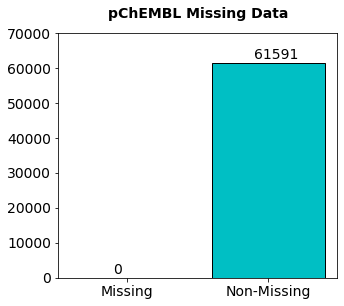

In [16]:
# Visualize the number of missing data
# Data
# https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb

import matplotlib.pyplot as plt

missing = df.pchembl_value.isnull().sum()
nonmissing = df.pchembl_value.notnull().sum()

x = ['Missing', 'Non-Missing']
y = [missing, nonmissing]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL Missing Data', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

In [26]:
# Non-missing data with pChEMBL value
import numpy as np
df2 = df[df.pchembl_value.notnull()]

In [27]:
# https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
print('Number of unique ChEMBL ID:', str(len(df.molecule_chembl_id.unique()) )  )
print('Total number of ChEMBL ID: ', str(len(df)) )
print('Number of missing ChEMBL ID: ', str(df.molecule_chembl_id.isnull().sum()) )

Number of unique ChEMBL ID: 61591
Total number of ChEMBL ID:  61591
Number of missing ChEMBL ID:  0


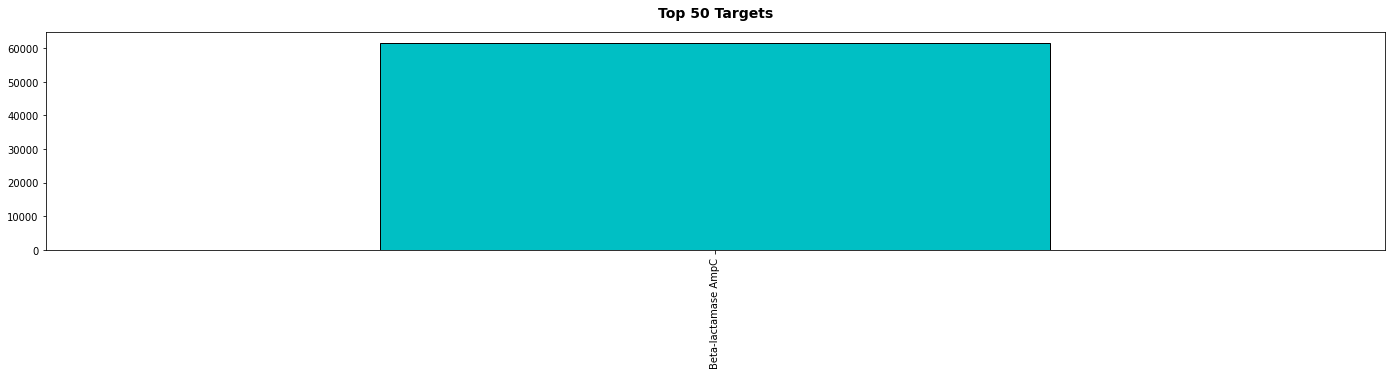

In [28]:
# https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
import matplotlib.pyplot as plt

unique = len(df.molecule_chembl_id.unique())
not_unique = len(df) - unique

x = ['Unique', 'Redundant']
y = [unique, not_unique]

df2.target_pref_name.value_counts()[0:50].plot.bar(figsize=(24,4), color='#00BFC4', ec='black')

plt.title('Top 50 Targets', fontsize=14, fontweight='black', pad=15)
plt.show()

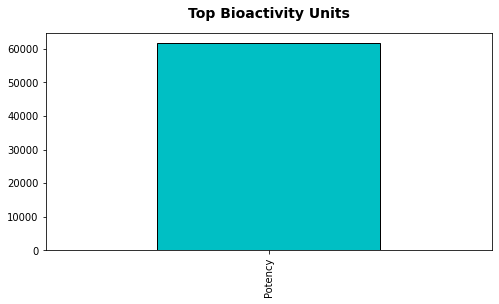

In [29]:
#https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
# Top 10 Bioactivity units
df2.standard_type.value_counts()[:10].plot.bar(figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Top Bioactivity Units', fontsize=14, fontweight='black', pad=15)
plt.show()

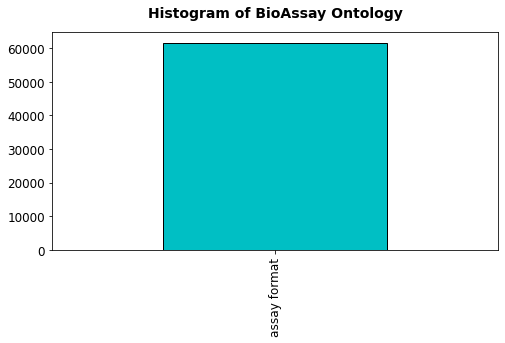

In [30]:
#https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
bao_labels = df2.bao_label.value_counts()
bao_labels.plot.bar(figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Histogram of BioAssay Ontology', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [31]:
bao_labels

assay format    61591
Name: bao_label, dtype: int64

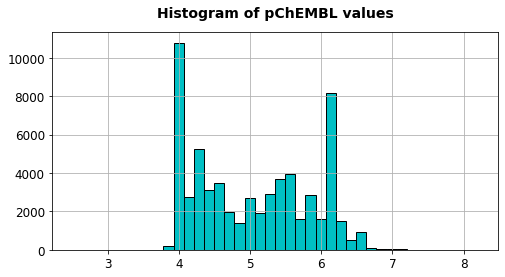

In [32]:
# https://github.com/dataprofessor/beta-lactamase/blob/main/beta_lactamase_data.ipynb
df2.pchembl_value.hist(bins=40, figsize=(8,4), color='#00BFC4', ec='black')
plt.title('Histogram of pChEMBL values', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
#Clean up Data folder after previous iteration of the script
!rm /content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/*.csv > NULL